In [ ]:
!pip install torch torchvision --quiet

import os
import glob
import random
import shutil
import time

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [ ]:
DATA_ROOT = "/content"
RAW_ZIP = os.path.join(DATA_ROOT, "mrlEyes_2018_01.zip")
RAW_DIR = os.path.join(DATA_ROOT, "mrlEyes_2018_01")

if not os.path.exists(RAW_ZIP):
    !wget -O /content/mrlEyes_2018_01.zip http://mrl.cs.vsb.cz/data/eyedataset/mrlEyes_2018_01.zip

if not os.path.exists(RAW_DIR):
    !unzip -q /content/mrlEyes_2018_01.zip -d /content

print("Done. Raw dir:", RAW_DIR)


--2025-12-03 07:18:55--  http://mrl.cs.vsb.cz/data/eyedataset/mrlEyes_2018_01.zip
Resolving mrl.cs.vsb.cz (mrl.cs.vsb.cz)... 158.196.145.190
Connecting to mrl.cs.vsb.cz (mrl.cs.vsb.cz)|158.196.145.190|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://mrl.cs.vsb.cz/data/eyedataset/mrlEyes_2018_01.zip [following]
--2025-12-03 07:18:56--  https://mrl.cs.vsb.cz/data/eyedataset/mrlEyes_2018_01.zip
Connecting to mrl.cs.vsb.cz (mrl.cs.vsb.cz)|158.196.145.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341866898 (326M) [application/zip]
Saving to: ‘/content/mrlEyes_2018_01.zip’

/content/mrlEyes_20 100%[===================>] 326.03M  20.3MB/s    in 17s     

2025-12-03 07:19:13 (19.4 MB/s) - ‘/content/mrlEyes_2018_01.zip’ saved [341866898/341866898]

Done. Raw dir: /content/mrlEyes_2018_01


In [ ]:
random.seed(42)

RAW_DIR = "/content/mrlEyes_2018_01"
OUT_ROOT = "/content/data_eyes"

all_pngs = glob.glob(os.path.join(RAW_DIR, "**", "*.png"), recursive=True)
print("Total PNGs found:", len(all_pngs))

open_files = []
closed_files = []

for path in all_pngs:
    fname = os.path.basename(path)
    parts = fname.split('_')
    if len(parts) < 5:
        continue
    eye_state = parts[4]  # '0' = closed, '1' = open in MRL
    if eye_state == '0':
        closed_files.append(path)
    elif eye_state == '1':
        open_files.append(path)

print("Open eye images:", len(open_files))
print("Closed eye images:", len(closed_files))

def split_list(lst, train_ratio=0.8, val_ratio=0.1):
    lst = lst.copy()
    random.shuffle(lst)
    n = len(lst)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)
    train = lst[:n_train]
    val = lst[n_train:n_train + n_val]
    test = lst[n_train + n_val:]
    return train, val, test

open_train, open_val, open_test = split_list(open_files)
closed_train, closed_val, closed_test = split_list(closed_files)

def copy_files(file_list, split, label_name):
    out_dir = os.path.join(OUT_ROOT, split, label_name)
    os.makedirs(out_dir, exist_ok=True)
    for src in file_list:
        dst = os.path.join(out_dir, os.path.basename(src))
        shutil.copy2(src, dst)

# Use 0_open → class 0, 1_closed → class 1
copy_files(open_train,   "train", "0_open")
copy_files(open_val,     "val",   "0_open")
copy_files(open_test,    "test",  "0_open")

copy_files(closed_train, "train", "1_closed")
copy_files(closed_val,   "val",   "1_closed")
copy_files(closed_test,  "test",  "1_closed")

print("Data prepared under:", OUT_ROOT)
for split in ["train", "val", "test"]:
    for cls in ["0_open", "1_closed"]:
        folder = os.path.join(OUT_ROOT, split, cls)
        cnt = len(glob.glob(os.path.join(folder, "*.png")))
        print(f"{split}/{cls}: {cnt} images")


Total PNGs found: 84898
Open eye images: 42952
Closed eye images: 41946
Data prepared under: /content/data_eyes
train/0_open: 34361 images
train/1_closed: 33556 images
val/0_open: 4295 images
val/1_closed: 4194 images
test/0_open: 4296 images
test/1_closed: 4196 images


In [ ]:
class NanoEyeCNN(nn.Module):
    """
    Jetson Nano–friendly CNN:
    - Input: 1 x 64 x 64 grayscale
    - Output: logits for 2 classes [open (0), closed (1)]
    ~137k parameters
    """
    def __init__(self, in_channels=1, num_classes=2):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels, 8, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64 -> 32

            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 32 -> 16

            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 16 -> 8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
data_root = "/content/data_eyes"

transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

train_dataset = datasets.ImageFolder(os.path.join(data_root, "train"), transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join(data_root, "val"),   transform=transform)
test_dataset  = datasets.ImageFolder(os.path.join(data_root, "test"),  transform=transform)

print("Class to index mapping:", train_dataset.class_to_idx)
# Should be: {'0_open': 0, '1_closed': 1}

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=64, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=2, pin_memory=True)


Class to index mapping: {'0_open': 0, '1_closed': 1}


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = NanoEyeCNN(in_channels=1, num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)
    return total_loss / total, correct / total

@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        total_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total   += labels.size(0)
    return total_loss / total, correct / total

EPOCHS = 10
best_val_acc = 0.0
best_state = None

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc     = eval_one_epoch(model, val_loader, criterion, device)
    dt = time.time() - t0

    print(f"Epoch {epoch:02d}/{EPOCHS:02d} | {dt:.1f}s | "
          f"Train {train_loss:.4f} / {train_acc*100:.2f}% | "
          f"Val {val_loss:.4f} / {val_acc*100:.2f}%")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_state = model.state_dict()


Using device: cuda
Epoch 01/10 | 42.0s | Train 0.2183 / 91.39% | Val 0.1064 / 95.96%
Epoch 02/10 | 40.7s | Train 0.1016 / 96.37% | Val 0.0677 / 97.67%
Epoch 03/10 | 39.4s | Train 0.0757 / 97.33% | Val 0.0581 / 98.01%
Epoch 04/10 | 39.3s | Train 0.0637 / 97.78% | Val 0.0489 / 98.21%
Epoch 05/10 | 40.8s | Train 0.0562 / 98.02% | Val 0.0461 / 98.40%
Epoch 06/10 | 39.6s | Train 0.0513 / 98.18% | Val 0.0432 / 98.46%
Epoch 07/10 | 39.3s | Train 0.0467 / 98.33% | Val 0.0404 / 98.55%
Epoch 08/10 | 39.6s | Train 0.0432 / 98.44% | Val 0.0402 / 98.54%
Epoch 09/10 | 39.4s | Train 0.0421 / 98.48% | Val 0.0434 / 98.52%
Epoch 10/10 | 39.3s | Train 0.0387 / 98.61% | Val 0.0365 / 98.65%


In [ ]:
OUT_PTH = "/content/eye_cnn_nano.pth"

if best_state is not None:
    model.load_state_dict(best_state)
    torch.save(best_state, OUT_PTH)
    print(f"\nSaved best model (val_acc={best_val_acc*100:.2f}%) to {OUT_PTH}")
else:
    torch.save(model.state_dict(), OUT_PTH)
    print("Saved last epoch weights to", OUT_PTH)

# Test set evaluation
test_loss, test_acc = eval_one_epoch(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f} | Test Acc: {test_acc*100:.2f}%")



Saved best model (val_acc=98.65%) to /content/eye_cnn_nano.pth
Test Loss: 0.0378 | Test Acc: 98.62%


In [ ]:
from google.colab import files
files.download("/content/eye_cnn_nano.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!ls -lh /content/eye_cnn_nano.pth


-rw-r--r-- 1 root root 541K Dec  3 07:26 /content/eye_cnn_nano.pth


In [ ]:
import torch
import numpy as np

model.eval()

all_labels = []
all_preds = []
all_probs_closed = []   # p(class=1) = "closed"

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits = model(imgs)              # [B, 2]
        probs = torch.softmax(logits, dim=1)  # [B, 2]

        preds = torch.argmax(probs, dim=1)    # predicted class index
        p_closed = probs[:, 1]                # probability of class 1 ("closed")

        all_labels.append(labels.cpu().numpy())
        all_preds.append(preds.cpu().numpy())
        all_probs_closed.append(p_closed.cpu().numpy())

all_labels = np.concatenate(all_labels)
all_preds = np.concatenate(all_preds)
all_probs_closed = np.concatenate(all_probs_closed)


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix
)

acc  = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds, average='binary', pos_label=1)
rec  = recall_score(all_labels, all_preds, average='binary', pos_label=1)
f1   = f1_score(all_labels, all_preds, average='binary', pos_label=1)

print(f"Accuracy       : {acc*100:.2f}%")
print(f"Precision (closed class): {prec*100:.2f}%")
print(f"Recall   (closed class): {rec*100:.2f}%")
print(f"F1-score (closed class): {f1*100:.2f}%\n")

# Full per-class report (open vs closed)
target_names = ["open (0)", "closed (1)"]
print("Classification report:\n")
print(classification_report(all_labels, all_preds, target_names=target_names, digits=4))


Accuracy       : 98.62%
Precision (closed class): 98.62%
Recall   (closed class): 98.59%
F1-score (closed class): 98.61%

Classification report:

              precision    recall  f1-score   support

    open (0)     0.9863    0.9865    0.9864      4296
  closed (1)     0.9862    0.9859    0.9861      4196

    accuracy                         0.9862      8492
   macro avg     0.9862    0.9862    0.9862      8492
weighted avg     0.9862    0.9862    0.9862      8492



Confusion matrix (rows = true, cols = predicted):

[[4238   58]
 [  59 4137]]


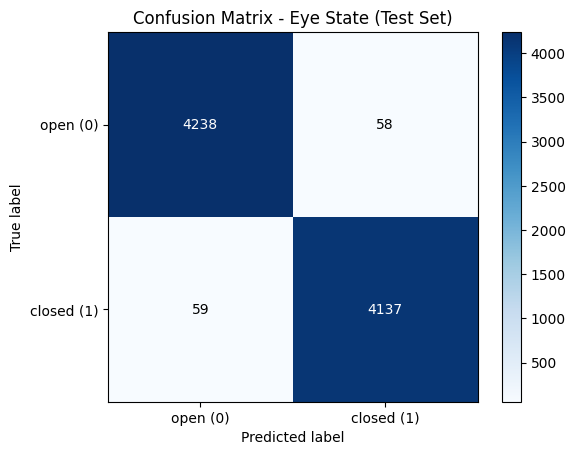

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(all_labels, all_preds, labels=[0, 1])
print("Confusion matrix (rows = true, cols = predicted):\n")
print(cm)

fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")

ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(["open (0)", "closed (1)"])
ax.set_yticklabels(["open (0)", "closed (1)"])
ax.set_title("Confusion Matrix - Eye State (Test Set)")

# annotate cells
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j],
                ha="center", va="center",
                color="white" if cm[i, j] > cm.max() / 2 else "black")

fig.colorbar(im, ax=ax)
plt.show()


ROC AUC (closed vs open): 0.9992


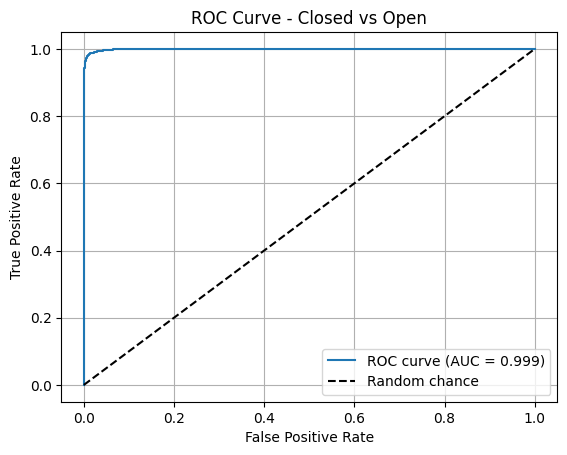

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

# Ground truth: 1 = closed (positive class)
y_true = all_labels
y_score = all_probs_closed  # p(class=1)

auc = roc_auc_score(y_true, y_score)
print(f"ROC AUC (closed vs open): {auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_true, y_score, pos_label=1)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Closed vs Open")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
===